In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from scipy.constants import h, c, k, sigma, G  # h in J*s, c in m/s, k in J/K
from matplotlib.ticker import ScalarFormatter
from scipy.integrate import quad, dblquad
from tqdm import tqdm
G = 6.674e-11  # Universal gravitational constant (m^3 kg^-1 s^-2)
c     = 2.9979e8 # Speed of light
M_sol   = 1.989e30 # Solar mass in kg
ld    = 2.59e13 # Light day in m

In [2]:
def redshift_wav(wavelenght, z):
    return np.array(wavelenght)*(1+z)

# Define the list of wavelengths
wavref = [3650, 4640, 6580, 8060, 9000, 10200] # Filter Wavelengths
wav_05 = redshift_wav(wavref,0.5)
wav_1 = redshift_wav(wavref,1)
wav_2 = redshift_wav(wavref,2)
print(wavref)
print(wav_05)
print(wav_1)
print(wav_2)

[3650, 4640, 6580, 8060, 9000, 10200]
[ 5475.  6960.  9870. 12090. 13500. 15300.]
[ 7300  9280 13160 16120 18000 20400]
[10950 13920 19740 24180 27000 30600]


# Light Curve Generation

6.307077625570776e+22 1.3990373181907725e+22
73.02664416807447
0.01216186000646368


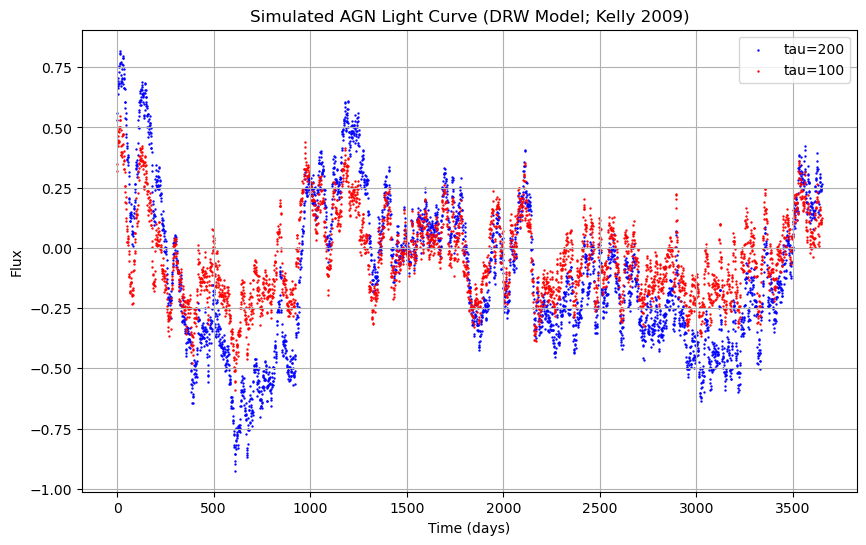

In [49]:
def relaxation_time(M, L, lam = 1):
    """
    Calculate the relaxation time of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in solar masses
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    tau_relax = 80.4*((lam*L/(10**45))**(-0.42)) * ((M/10**8)**1.03)
    ### Need correcting
    tau_relax_error = tau_relax - (80.4+66.9)*(lam*L/(10**45))**(-0.42+0.28) * (M/10**8)**(1.03+0.38)
    return tau_relax, tau_relax_error    

def drw_sigma(M, L, lam = 1):
    """
    Calculate the long-term variation amplitude of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in solar masses
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    log_sigma2 = -3.83-0.09*np.log(lam*L/10**45) * -0.25*np.log(M/10**8)
    sigma = np.sqrt(10**log_sigma2)

    ### Need correcting
    sigma_error = sigma - (0.18+0.11)*(lam*L/(10**45))**(0.18-0.09) * (M/10**8)**(0.18+0.09)
    return sigma, sigma_error

def generate_damped_RW(t_rest,mean_flux=0 ,tau=200,z=0,b=0,sigma=0.03,seed=0):
    """
    Simulates an AGN light curve using the Damped Random Walk (DRW) model (Kelly 2009).

    Parameters
    ----------
    t_rest (array_like): rest-frame time (sorted).  
    mean_flux (float): mean flux; default=10
    tau (float): relaxation time
    z (float): redshift
    mean_vari (float): mean light curve variation; default=0
    b (float): mean variation amplitude; default=0
    sigma (float): long-term variation amplitude; default=1
    seed (int): random seed for np.random

    Returns
    -------
    x (ndarray): Flux values at each time in t_rest
    """
    np.random.seed(seed)
    mean_vari = b * tau
    variance = sigma * np.sqrt(tau / 2)

    N = len(t_rest)

    t_obs = t_rest * (1 + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(mean_vari, variance)
    epsilon = np.random.normal(0, 1, N) # White noise
    #dX(t) = -X(t) * dt + sigma * sqrt(tau) * e(t) * sqrt(dt) + b * tau * dt
    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1] - dt * (x[i - 1] - mean_vari) 
                + sigma * np.sqrt(tau) * epsilon[i] * np.sqrt(dt)
                +b * tau * dt)

    x = x + mean_flux
    return x, t_obs

def eddington_acc(M, effi = 0.1):
    """
    Calculate the Eddington accretion rate of an AGN.
    Parameters
    ----------
    M (float): Black hole mass in kg
    effi (float): Eddington efficiency; default=0.1
    """
    M_p = 1.6726219e-27 # Proton mass in kg
    t_cross_sec = 6.6524587e-29 # Thomson cross section in m^2
    M_dot = 4*np.pi*G*M*M_p/(effi*c*t_cross_sec) # Eddington accretion rate in kg/s
    return M_dot

# Time points (e.g., over 5 years with random sampling)
days = np.arange(0.0,10 * 365,1)#np.sort(np.random.uniform(0, 5 * 365, 5*365))
M = 10**8 * M_sol # Black hole mass in kg
M_dot = 1*M_sol/(365*24*3600) # kg per second
M_dot_edd = eddington_acc(M)*0.1
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s
print(M_dot, eddington_acc(M)*0.1)
print(relaxation_time(10**8,L)[0])
print(drw_sigma(10**8,L)[0])
# Simulate the light curve
light_curve, t_obs = generate_damped_RW(days)
light_curve_1, t_obs_1 = generate_damped_RW(days,mean_flux=0,tau=200,z=0.5,b=0,sigma=0.03,seed=0)
light_curve_2, t_obs_2 = generate_damped_RW(days,mean_flux=0,tau=relaxation_time(10**8,L)[0],z=0.5,b=0.,sigma=0.03,seed=0)
# Plot the simulated light curve
plt.figure(figsize=(10, 6))
#normalised_lc = (light_curve - min(light_curve))/(max(light_curve)-min(light_curve))
#plt.scatter(days, normalised_lc, s=0.5, color='red')
#print(max(light_curve),min(light_curve))
plt.scatter(days,light_curve_1 , s=0.5, label='tau=200', color='blue')
plt.scatter(days,light_curve_2 , s=0.5, label='tau=100', color='red')
#plt.scatter(days,light_curve_z, s=0.5, color='red')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.title('Simulated AGN Light Curve (DRW Model; Kelly 2009)')
plt.grid(True)
plt.legend()
plt.show()


In [50]:
from sklearn.utils import check_random_state
def generate_damped_RW(t_rest, tau=300., z=2.0,
                       xmean=0, SFinf=0.3, random_state=None):
    """Generate a damped random walk light curve

    This uses a damped random walk model to generate a light curve similar
    to that of a QSO [1]_.

    Parameters
    ----------
    t_rest : array_like
        rest-frame time.  Should be in increasing order
    tau : float
        relaxation time
    z : float
        redshift
    xmean : float (optional)
        mean value of random walk; default=0
    SFinf : float (optional
        Structure function at infinity; default=0.3
    random_state : None, int, or np.random.RandomState instance (optional)
        random seed or random number generator

    Returns
    -------
    x : ndarray
        the sampled values corresponding to times t_rest

    Notes
    -----
    The differential equation is (with t = time/tau):

        dX = -X(t) * dt + sigma * sqrt(tau) * e(t) * sqrt(dt) + b * tau * dt

    where e(t) is white noise with zero mean and unit variance, and

        Xmean = b * tau
        SFinf = sigma * sqrt(tau / 2)

    so

        dX(t) = -X(t) * dt + sqrt(2) * SFint * e(t) * sqrt(dt) + Xmean * dt

    References
    ----------
    .. [1] Kelly, B., Bechtold, J. & Siemiginowska, A. (2009)
           Are the Variations in Quasar Optical Flux Driven by Thermal
           Fluctuations? ApJ 698:895 (2009)
    """
    #  Xmean = b * tau
    #  SFinf = sigma * sqrt(tau / 2)
    t_rest = np.atleast_1d(t_rest)

    if t_rest.ndim != 1:
        raise ValueError('t_rest should be a 1D array')

    random_state = check_random_state(random_state)

    N = len(t_rest)

    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = random_state.normal(xmean, SFinf)
    E = random_state.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))

    return x

In [51]:
def FT_continuous(t, h, axis=-1, method=1):
    r"""Approximate a continuous 1D Fourier Transform with sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

       H(f) = \int h(t) exp(-2 \pi i f t) dt

    It returns f and H, which approximate H(f).

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    H : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    Dt = t[1] - t[0]
    Df = 1. / (N * Dt)
    t0 = t[N // 2]

    f = Df * (np.arange(N) - N // 2)

    shape = np.ones(h.ndim, dtype=int)
    shape[axis] = N

    phase = np.ones(N)
    phase[1::2] = -1
    phase = phase.reshape(shape)

    if method == 1:
        H = Dt * np.fft.fft(h * phase, axis=axis)
    else:
        H = Dt * np.fft.fftshift(np.fft.fft(h, axis=axis), axes=axis)

    H *= phase
    H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))
    H *= np.exp(-1j * np.pi * N / 2)

    return f, H

def PSD_continuous(t, h, axis=-1, method=1):
    r"""Approximate a continuous 1D Power Spectral Density of sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

        H(f) = \int h(t) \exp(-2 \pi i f t) dt

    It returns f and PSD, which approximate PSD(f) where

    .. math::

        PSD(f) = |H(f)|^2 + |H(-f)|^2

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    PSD : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    ax = axis % h.ndim

    if method == 1:
        # use FT_continuous
        f, Hf = FT_continuous(t, h, axis)
        Hf = np.rollaxis(Hf, ax)
        f = -f[N // 2::-1]
        PSD = abs(Hf[N // 2::-1]) ** 2
        PSD[:-1] += abs(Hf[N // 2:]) ** 2
        PSD = np.rollaxis(PSD, 0, ax + 1)
    else:
        # A faster way to do it is with fftshift
        # take advantage of the fact that phases go away
        Dt = t[1] - t[0]
        Df = 1. / (N * Dt)
        f = Df * np.arange(N // 2 + 1)
        Hf = np.fft.fft(h, axis=axis)
        Hf = np.rollaxis(Hf, ax)
        PSD = abs(Hf[:N // 2 + 1]) ** 2
        PSD[-1] = 0
        PSD[1:] += abs(Hf[N // 2:][::-1]) ** 2
        PSD[0] *= 2
        PSD = Dt ** 2 * np.rollaxis(PSD, 0, ax + 1)

    return f, PSD

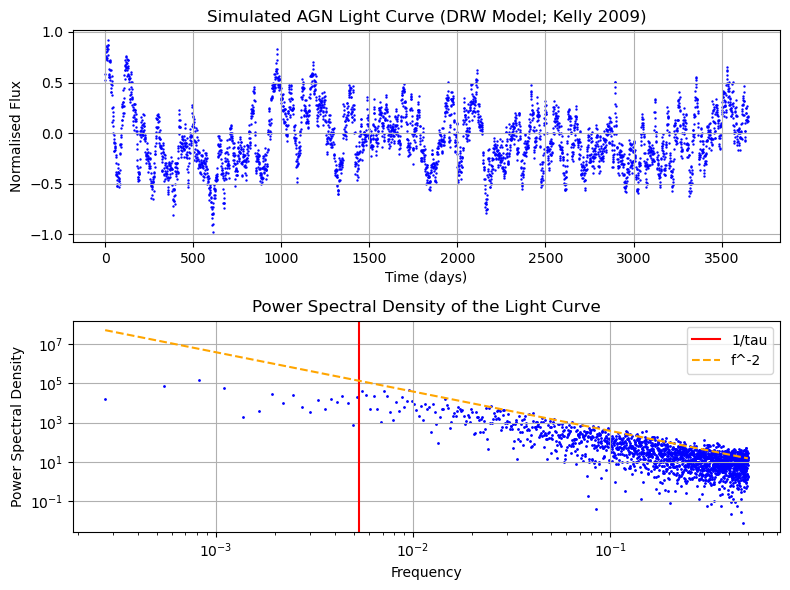

In [52]:
from scipy.signal import periodogram

days = np.arange(0.0, 10 * 365, 1)
days1 = np.arange(0.0, 10 * 365, 5)
relax_tau = 30
light_curve = generate_damped_RW(days,tau = relax_tau, z=0.0, random_state=0)
light_curve_1 = generate_damped_RW(days1, z=0.0, random_state=0)



# Compute the power spectral density
frequencies, psd = periodogram(light_curve)
alpha = psd[-1] / frequencies[-1]**-2
f, PSD = PSD_continuous(days, light_curve)
alpha = PSD[-1] / f[-1]**-2

frequencies1, psd1 = periodogram(light_curve_1)
alpha1 = psd1[-1] / frequencies1[-1]**-2

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the simulated light curve
#axs[0].scatter(days, normalised_lc, s=0.5, color='blue')
axs[0].scatter(days,light_curve , s=0.5, color='blue')
#axs[0].scatter(days1,light_curve_1 , s=0.5, color='red')
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Normalised Flux')
axs[0].set_title('Simulated AGN Light Curve (DRW Model; Kelly 2009)')
axs[0].grid(True)

# Plot the power spectral density
#axs[1].scatter(frequencies, psd, s=1, color='blue')
axs[1].scatter(f, PSD, s=1, color='blue')
axs[1].axvline(1/(2*np.pi*relax_tau), color='red', label='1/tau')
# Plot a line proportional to frequency^-2 for comparison
axs[1].loglog(f[1:], alpha*(f[1:]**-2), label='f^-2', linestyle='--', color='orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power Spectral Density')
axs[1].set_title('Power Spectral Density of the Light Curve')
#axs[1].set_ylim(1e-6, 1e5)
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Temperature Profile SI

In [53]:
def temp_r(radius, M, M_dot, hx, albedo, efficiency, r_in):
    """
    Calculate the temperature of an accretion disk at a given radius.

    Parameters
    ----------
    radius (float): radius in light days
    M (float): mass of the black hole in solar masses
    M_dot (float): accretion rate in solar masses per year
    hx (float): height of the disk at the radius in gravitational radii
    albedo (float): albedo of the disk
    efficiency (float): efficiency parameter
    """
    M_sol   = 1.989e30  # Solar mass in kg
    ld    = 2.59e13 # Light day in m

    rs    = 2*G*M/c**2 # Schwarzschild radius in m
    r_in = r_in*rs # Inner radius of the disk in m
    hx    = hx*rs # Height of lamp in m
    Lb    = efficiency*M_dot*c**2 # Luminosity of the disk in W

    temp_vis = (3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius)))**(1/4)
    temp_irr = ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt((radius**2)+(hx**2)))**3))**(1/4)
    temp_tot = ((3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius))) 
             + ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt(((radius)**2)+(hx**2)))**3)) )**(1/4)
    return temp_tot, temp_vis, temp_irr


def weins_law(T): #angstrom
    return  0.0029* 1e10/T 



### Starkey 2016 Fig 1, R_in = Rs

295404221161.55774
0.5


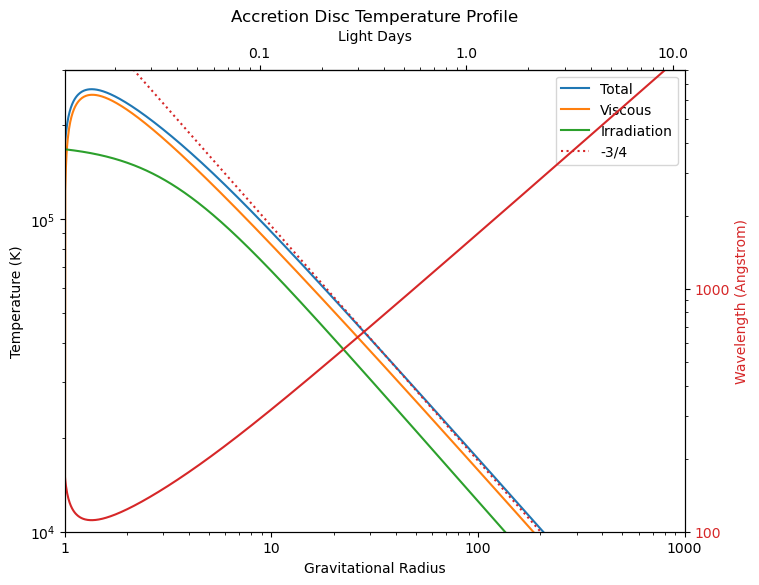

In [54]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 1 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

print(rs)
radii = np.logspace(np.log10(rs+1), np.log10(rs*1000), 1000) #m
print(radii[999]-rs*1000)
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

emitting_lambda = weins_law(temp_prof)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.plot(radii/rs, (3e0*(radii[999]/rs)/(radii[999]/rs)**(-3/4))*(radii/rs)**(-3/4)
         , label='-3/4', linestyle=':')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(1, 1000)
axs.legend()
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.set_ylim(100,8000)
#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

#fig.suptitle('Temp prof') 

### Temperature Profile R_in = 3 Rs

18531.664869412354


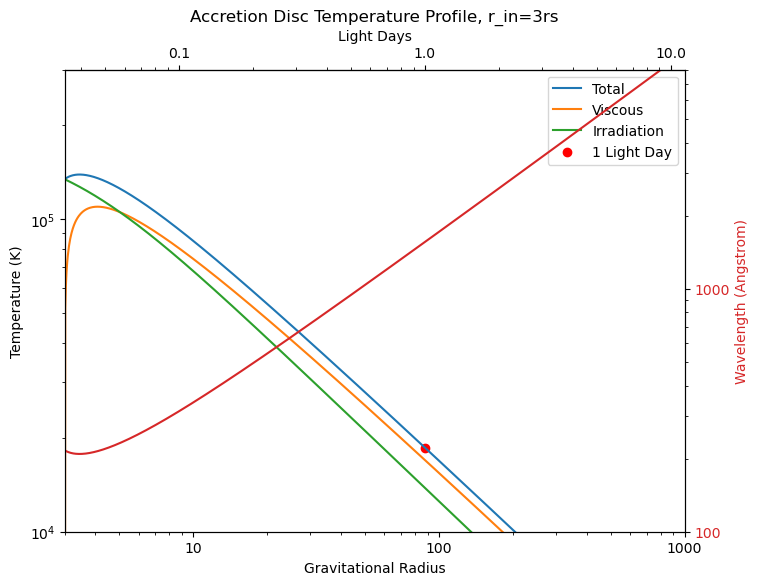

In [55]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)
temp_r0_index = np.where(radii >= ld)[0]
#print(temp_r0_index)	
temp_r0 = temp_prof[temp_r0_index[0]]
print(temp_r0)
emitting_lambda = weins_law(temp_prof)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(r_in, 1000)
axs.legend()
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.set_ylim(100,8000)
#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

#fig.suptitle('Temp prof') 

In [56]:
from scipy.integrate import quad

inclination = 0
D = 1.327e+23 # 4.3 Mpc
def Mpc2Cm(d):
    return d*3.086e24
distance = Mpc2Cm(4.3) # Mpc to cm
erg = 1e7 # J to erg

# Define the Planck function, F_nu
def planck_function(freq, temp):
    # Computes black body intensity (J/m^2/s/Hz/sr) at given temperature and frequency.

    c1 = (2 * k**3)/(c**2 * h**2) # (2kb^3)/(c^2h^2)
    c2 = h / k # h/kb
    
    x = c2 * freq / temp

    if (x < 1e-5): # Rayleigh-Jeans tail
        Planck = c1*(x**2)*(temp**3)
    else:
        Planck = c1*(x**3)*(temp**3) / (np.expm1(x))
    return Planck

# Define the integrand for the emitted spectrum
def integrand(r, lam):
    temp_prof, _, _ = temp_r(r, M, M_dot, hx, albedo, efficiency, r_in)
    if np.isnan(temp_prof):
        return 0
    freq = c / lam
    return planck_function(freq, temp_prof) * 2 * np.pi * r * np.cos(inclination) ##/ D**2

# Define the wavelength range (in meters)
wavelengths = np.linspace(1e-8, 1e-5, 10000)  # Wavelength in meters
#wavelengths = np.logspace(np.log10(1e-8), np.log10(1e-5), 10000)  # Wavelength in meters
# Define the radius range (in rs)
r_min = rs*3 #m
r_max = (rs*1000) #m
print(r_min/ld, r_max/ld)

# Compute the emitted spectrum by integrating over the radius range
emitted_spectrum = []
for lam in wavelengths:
    spectrum, _ = quad(integrand, r_min, r_max, args=(lam,),limit=50)
    #spectrum = spectrum*()
    emitted_spectrum.append(spectrum)

# Convert the emitted spectrum to a numpy array
emitted_spectrum = np.array(emitted_spectrum)

0.034216705153848385 11.40556838461613


In [57]:
background_L = []
for wav in wavref:
    index = np.where((wavelengths >= 0.999*(wav*1e-10)) & (wavelengths <= 1.001*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    print(wav, emitted_spectrum[index][0])

3650 1.1682271353192566e+22
4640 1.1007679176834437e+22
6580 9.90062491609585e+21
8060 9.111491721523845e+21
9000 8.617728870821696e+21
10200 8.001074988496661e+21


Text(0.5, 1.0, 'Background spectrum')

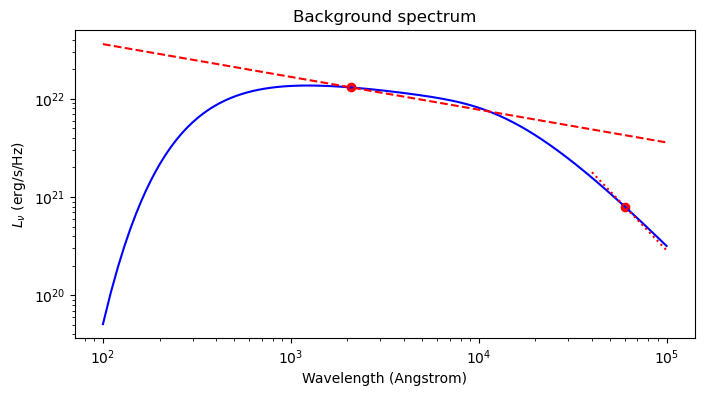

In [58]:
# Create subplots
rayleigh_jean_tail = 6000
weins_tail = 200
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(wavelengths * 1e+10, emitted_spectrum, color='blue')
axs.scatter(wavelengths[weins_tail] * 1e+10, emitted_spectrum[weins_tail], color='red')
axs.scatter(wavelengths[rayleigh_jean_tail] * 1e+10, emitted_spectrum[rayleigh_jean_tail], color='red')
alpha1 = (emitted_spectrum[weins_tail])/(wavelengths[weins_tail]**-(1/3))#(wavelengths[100])/(emitted_spectrum[100]) 
alpha2 = (emitted_spectrum[rayleigh_jean_tail])/(wavelengths[rayleigh_jean_tail])**(-2)
axs.plot(wavelengths * 1e+10, alpha1*((wavelengths)**(-1/3)), color='red', linestyle='--')
axs.plot(wavelengths[4000:] * 1e+10, alpha2*(wavelengths[4000:])**(-2), color='red', linestyle=':')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Wavelength (Angstrom)')
axs.set_ylabel(r'$L_\nu$ (erg/s/Hz)')
axs.set_title('Background spectrum')
#axs[1].plot(c/wavelengths , emitted_spectrum, color='blue')
#axs[1].plot(c/wavelengths, (1e-29)*(c/wavelengths)**(1/3), color='red', linestyle='--')
#axs[1].set_yscale('log')
#axs[1].set_xscale('log')
#axs[1].set_xlabel('Frequency (Hz)')
#axs[1].set_ylabel("Flux Density (erg/s/cm^2/Hz)")

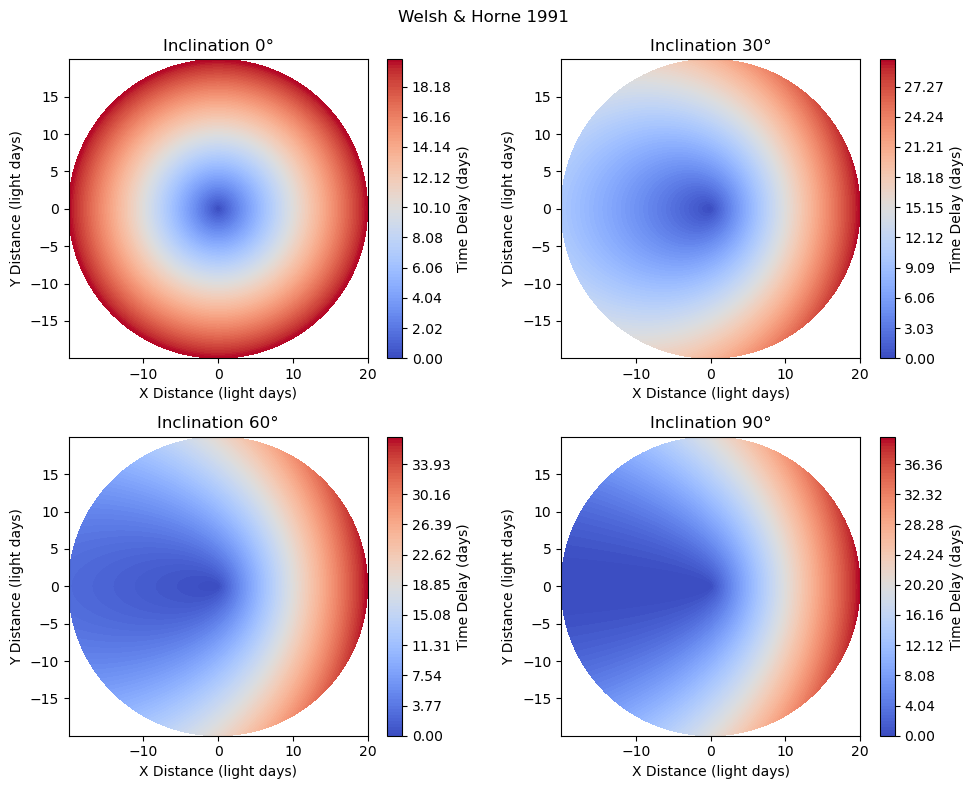

In [59]:
inclinations = [0, 30, 60, 90]  # Inclination angles in degrees

# Define radius and azimuth range in light days

radii = np.linspace(0, 20, 100)# in light days
azimuths = np.linspace(0, 360, 360)
R, Phi = np.meshgrid(radii, azimuths, indexing='ij')

# Function to compute time delay in seconds
def time_delay(r, phi, i):
    """Calculate time delay for given radius, azimuth, and inclination."""
    return (r) / c * (1 + np.cos(np.radians(phi)) * np.sin(np.radians(i)))

# Convert polar coordinates to Cartesian coordinates for plotting
X = R * np.cos(np.radians(Phi))
Y = R * np.sin(np.radians(Phi))

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, i in enumerate(inclinations):
    delays = (time_delay(R*2.59e+13, Phi, i))/(3600*24) # in days
    levels = np.linspace(np.min(delays), np.max(delays), 100)
    
    ax = axes[idx]
    contour = ax.contourf(X, Y, delays, levels=levels, cmap='coolwarm')
    ax.set_title(f'Inclination {i}°')
    ax.set_xlabel('X Distance (light days)')
    ax.set_ylabel('Y Distance (light days)')
    fig.colorbar(contour, ax=ax, label='Time Delay (days)')
    ax.set_aspect('equal')  # Ensure the disc is centered and proportional
fig.suptitle('Welsh & Horne 1991') 

plt.tight_layout()
plt.show()


886212663484.6732


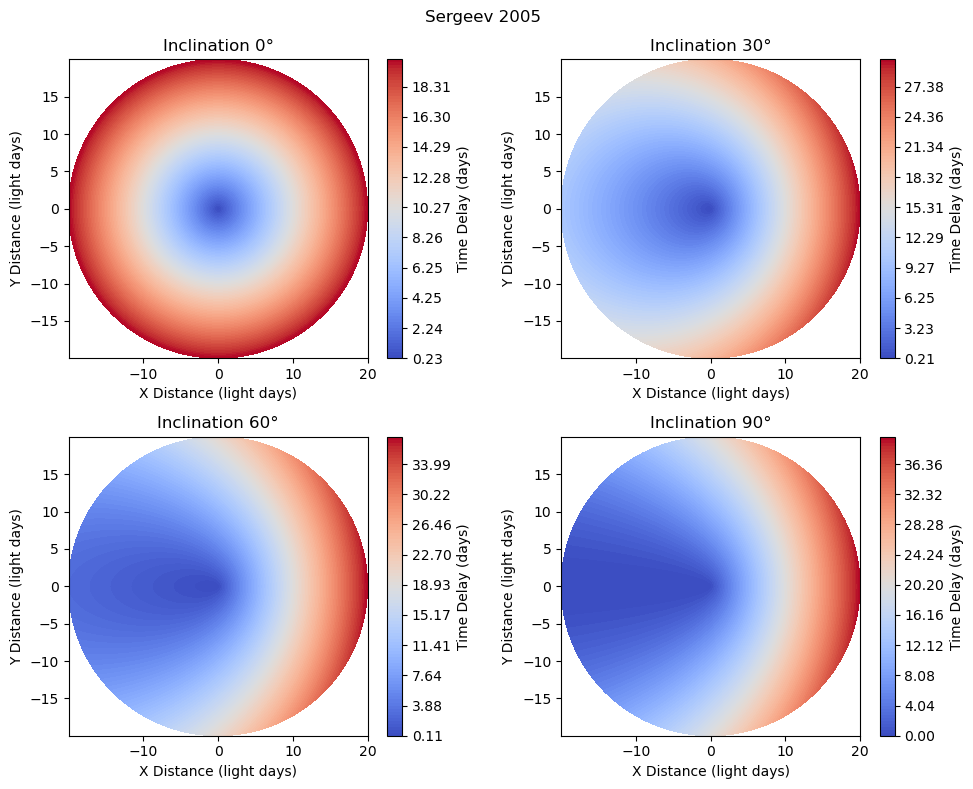

In [60]:
inclinations = [0, 30, 60, 90]  # Inclination angles in degrees

# Define radius and azimuth range in light days

radii = np.linspace(0, 20, 100)# in light days
azimuths = np.linspace(0, 360, 360)
R, Phi = np.meshgrid(radii, azimuths, indexing='ij')

# Function to compute time delay in seconds
def time_delay_sergeev(r, phi, i, hx):
    """Calculate time delay for given radius, azimuth, and inclination."""
    return (1 / c) * (np.sqrt(r**2 + hx**2) + r*np.cos(np.radians(phi)) * np.sin(np.radians(i))+hx*np.cos(np.radians(i)))

# Convert polar coordinates to Cartesian coordinates for plotting
X = R * np.cos(np.radians(Phi))
Y = R * np.sin(np.radians(Phi))

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
print(hx*rs)
for idx, i in enumerate(inclinations):
    delays = (time_delay_sergeev(R*2.59e+13, Phi, i,10*rs))/(3600*24) # in days
    levels = np.linspace(np.min(delays), np.max(delays), 100)
    
    ax = axes[idx]
    contour = ax.contourf(X, Y, delays, levels=levels, cmap='coolwarm')
    ax.set_title(f'Inclination {i}°')
    ax.set_xlabel('X Distance (light days)')
    ax.set_ylabel('Y Distance (light days)')
    fig.colorbar(contour, ax=ax, label='Time Delay (days)')
    ax.set_aspect('equal')  # Ensure the disc is centered and proportional
fig.suptitle('Sergeev 2005') 

plt.tight_layout()
plt.show()


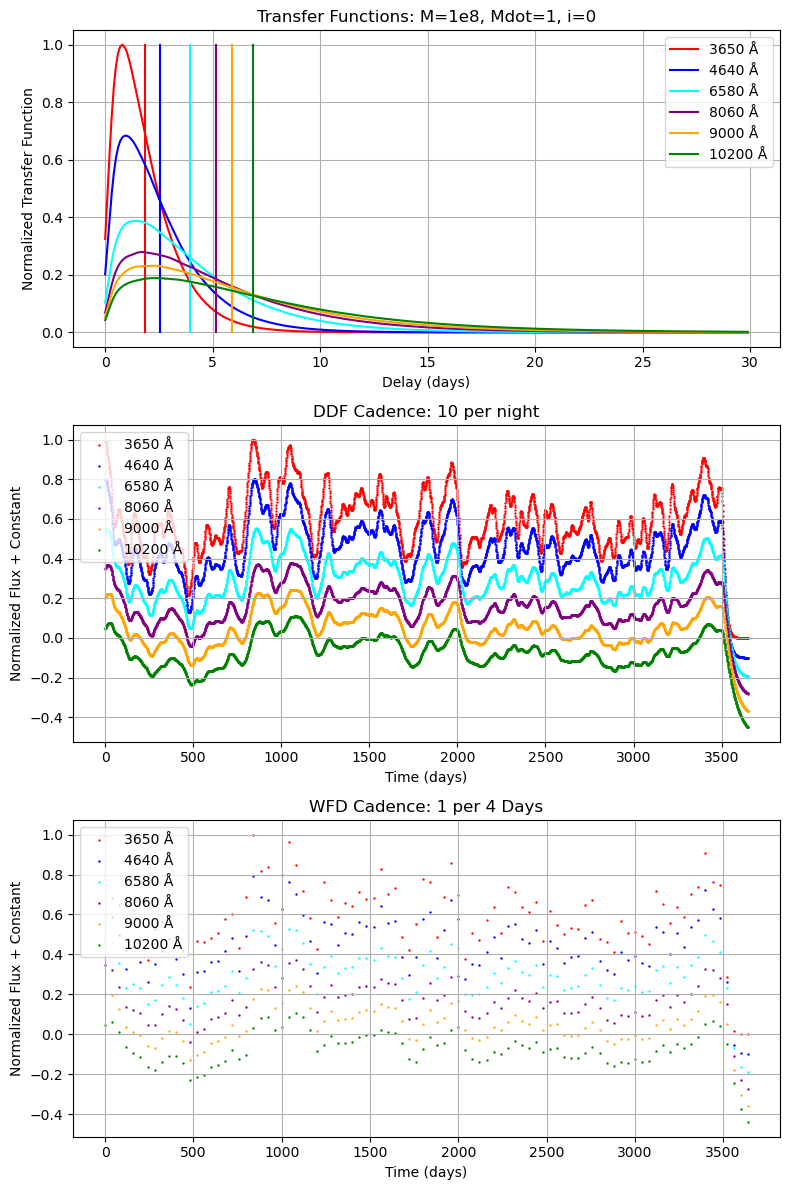

In [61]:
from scipy.signal import convolve
import csv
# Define the list of wavelengths
wavref = [3650, 4640, 6580, 8060, 9000, 10200]
mean_delay = []
color=['r','b','cyan','purple','orange','green','skyplue','magenta']
cadence = 10
normalised_lc = (light_curve - min(light_curve))/(max(light_curve)-min(light_curve))
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
for i, wav in enumerate(wavref):
    filename = '../Transfer_function/1e8M_1Mdot_0Deg/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == 3650.:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    mean_delay.append(mean)
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    errors = abs(np.random.normal(0, 0.05, size=len(normalize_convolved_light_curve)))
    # Normalize the convolved light curve
    #convolved_light_curve = convolved_light_curve #/ max(convolved_light_curve)
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    
    # Plot the convolved light curve
    axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]-i*0.1,s=0.5,color=color[i], label=f'{int(wav)} Å')
    axs[2].scatter(days[::40], normalize_convolved_light_curve[::40]-i*0.1,s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]+background_L[i],s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[2].scatter(days[::40], normalize_convolved_light_curve[::40]+background_L[i],s=0.5,color=color[i], label=f'{int(wav)} Å')

    with open( '../Transfer_function/1e8M_1MDot_0Deg/' +str(wav)+'_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux','error'])  # Write the header
        for tau, flux, error  in zip(days, normalize_convolved_light_curve, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux + Constant')
axs[1].set_title('DDF Cadence: 10 per night')
axs[1].legend()
axs[1].grid()

axs[2].set_xlabel('Time (days)')
axs[2].set_ylabel('Normalized Flux + Constant')
axs[2].set_title('WFD Cadence: 1 per 4 Days')
axs[2].legend()
axs[2].grid()


plt.tight_layout()

plt.show()

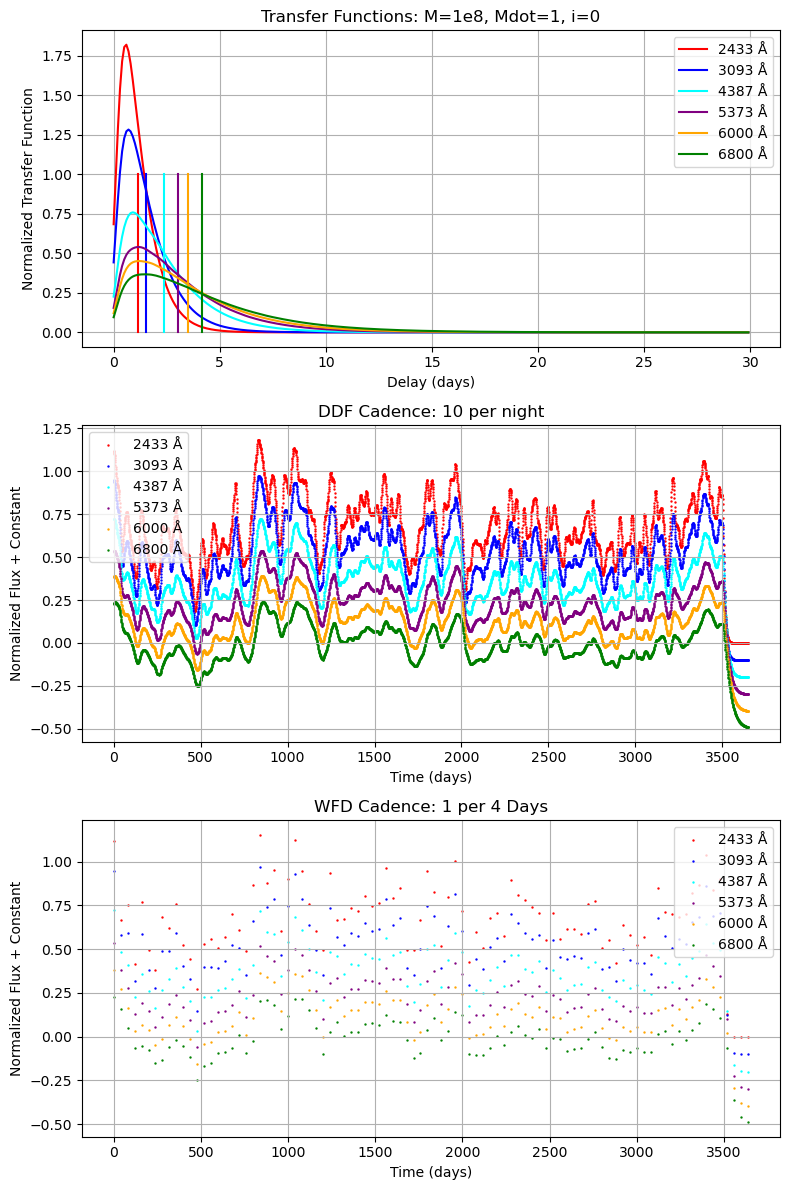

In [62]:
from scipy.signal import convolve
import csv
# Define the list of wavelengths
wavref = [3650, 4640, 6580, 8060, 9000, 10200]
redshift_wav = [2433, 3093, 4387, 5373, 6000, 6800]
mean_delay = []
color=['r','b','cyan','purple','orange','green','skyplue','magenta']
cadence = 10
normalised_lc = (light_curve - min(light_curve))/(max(light_curve)-min(light_curve))
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
for i, wav in enumerate(redshift_wav):
    filename = '../Transfer_function/1e8M_1MDot_0Deg_z05/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == 3650.:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    mean_delay.append(mean)
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    errors = abs(np.random.normal(0, 0.05, size=len(normalize_convolved_light_curve)))
    # Normalize the convolved light curve
    #convolved_light_curve = convolved_light_curve #/ max(convolved_light_curve)
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    
    # Plot the convolved light curve
    axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]-i*0.1,s=0.5,color=color[i], label=f'{int(wav)} Å')
    axs[2].scatter(days[::40], normalize_convolved_light_curve[::40]-i*0.1,s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]+background_L[i],s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[2].scatter(days[::40], normalize_convolved_light_curve[::40]+background_L[i],s=0.5,color=color[i], label=f'{int(wav)} Å')

    with open( '../Transfer_function/1e8M_1MDot_0Deg/' +str(wav)+'_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux','error'])  # Write the header
        for tau, flux, error  in zip(days, normalize_convolved_light_curve, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux + Constant')
axs[1].set_title('DDF Cadence: 10 per night')
axs[1].legend()
axs[1].grid()

axs[2].set_xlabel('Time (days)')
axs[2].set_ylabel('Normalized Flux + Constant')
axs[2].set_title('WFD Cadence: 1 per 4 Days')
axs[2].legend()
axs[2].grid()


plt.tight_layout()

plt.show()

In [16]:
lower_clip = 100
upper_clip = 17500
time_step = 2
len(normalize_convolved_light_curve[lower_clip:upper_clip:time_step])


1775

In [17]:
print(mean_delay)

[1.8713164731253855, 2.5333723847730747, 3.969318801101565, 5.153191091978206, 5.921576160485186, 6.892298989930033]


In [18]:
#data_headers = ['delay','flux']
# Import template spectra here
lc_3650 = pd.read_csv('../Transfer_function/1e8M_1MDot_0Deg/3650_light_curve.csv')
lc_4640 = pd.read_csv('../Transfer_function/1e8M_1MDot_0Deg/4640_light_curve.csv')
lc_6580 = pd.read_csv('../Transfer_function/1e8M_1MDot_0Deg/6580_light_curve.csv')
lc_8060 = pd.read_csv('../Transfer_function/1e8M_1MDot_0Deg/8060_light_curve.csv')
lc_9000 = pd.read_csv('../Transfer_function/1e8M_1MDot_0Deg/9000_light_curve.csv')
lc_10200 = pd.read_csv('../Transfer_function/1e8M_1MDot_0Deg/10200_light_curve.csv')
ts_list = [lc_3650,lc_4640,lc_6580,lc_8060,lc_9000,lc_10200]

### Generating Optimum AGN

In [23]:
# Time points (e.g., over 5 years with random sampling)
days = np.arange(0.0,10 * 365,0.1)
M = 10**8 #* M_sol # Black hole mass in kg
M_dot_edd = eddington_acc(M* M_sol)*0.1
print(M_dot_edd)
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s
tau_relax = relaxation_time(M,L)[0]
sigma_var = drw_sigma(10**8,L)[0]
print(tau_relax,np.log(tau_relax), sigma_var)
# Simulate the light curve
light_curve_05, t_obs_05 = generate_damped_RW(days,mean_flux=0,tau=tau_relax,z=0.5,b=0,sigma=sigma_var,seed=0)
light_curve_1, t_obs_1 = generate_damped_RW(days,mean_flux=0,tau=tau_relax,z=1,b=0.,sigma=sigma_var,seed=0)
light_curve_2, t_obs_2 = generate_damped_RW(days,mean_flux=0,tau=tau_relax,z=2,b=0.,sigma=sigma_var,seed=0)

1.3990373181907725e+22
73.02664416807447 4.290824363160014 0.01216186000646368


c:\Users\nikko\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


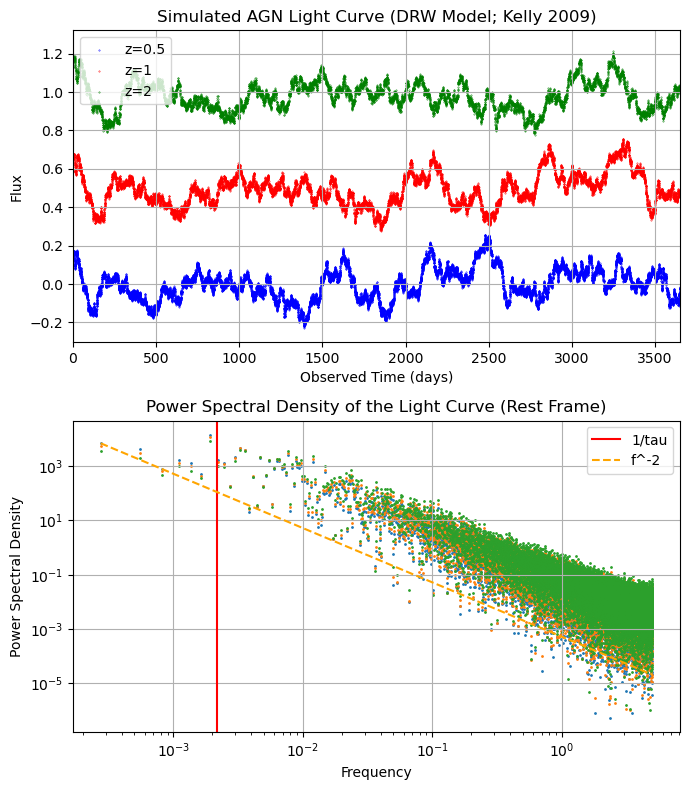

In [24]:
"""
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(days*1.5,light_curve_05 , s=0.1, label='z=0.5', color='blue')
ax.scatter(days*2,light_curve_1 , s=0.1, label='z=1', color='red')
ax.scatter(days*3,light_curve_2 , s=0.1, label='z=2', color='green')
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('Flux')
"""
# Compute the power spectral density
f_05, PSD_05 = PSD_continuous(days, light_curve_05)
f_1, PSD_1 = PSD_continuous(days, light_curve_1)
f_2, PSD_2 = PSD_continuous(days, light_curve_2)


alpha = PSD_05[1] / f_05[1]**-2

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(7, 8))

# Plot the simulated light curve
#axs[0].scatter(days, normalised_lc, s=0.5, color='blue')
axs[0].scatter(days*1.5,light_curve_05 , s=0.1, label='z=0.5', color='blue')
axs[0].scatter(days*2,light_curve_1 + 0.5 , s=0.1, label='z=1', color='red')
axs[0].scatter(days*3,light_curve_2 + 1, s=0.1, label='z=2', color='green')
axs[0].set_xlabel('Observed Time (days)')
axs[0].set_ylabel('Flux')
axs[0].set_title('Simulated AGN Light Curve (DRW Model; Kelly 2009)')
axs[0].set_xlim(0, 3650)
axs[0].legend()
axs[0].grid(True)

# Plot the power spectral density
axs[1].scatter(f_05, PSD_05, s=1)
axs[1].scatter(f_1, PSD_1, s=1)
axs[1].scatter(f_2, PSD_2, s=1)
# Plot a line proportional to frequency^-2 for comparison
#axs[1].loglog(frequencies[1:], alpha*(frequencies[1:]**-2), label='f^-2', linestyle='--')
axs[1].axvline(1/(2*np.pi*tau_relax), color='red', label='1/tau')
# Plot a line proportional to frequency^-2 for comparison
axs[1].loglog(f_05[1:], alpha*(f_05[1:]**-2), label='f^-2', linestyle='--', color='orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power Spectral Density')
axs[1].set_title('Power Spectral Density of the Light Curve (Rest Frame)')
#axs[1].set_ylim(1e-6, 1e3)
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Redshifted Wavelengths

In [27]:
def redshift_wav(wavelenght, z):
    return np.array(wavelenght)*(1+z)

def deredshift_wav(wavelength, z):
    return np.array(wavelength)/(1+z)

# Define the list of wavelengths
wavref = [3650, 4640, 6580, 8060, 9000, 10200] # Filter Wavelengths
wav_05 = redshift_wav(wavref,0.5)
wav_1 = redshift_wav(wavref,1)
wav_2 = redshift_wav(wavref,2)
print('Filters:',wavref)
print('z=0.5',wav_05)
print('z=1',wav_1)
print('z=2',wav_2)
print('De-redshift')
ders_wav_05 = deredshift_wav(wavref,0.5)
ders_wav_1 = deredshift_wav(wavref,1)
ders_wav_2 = deredshift_wav(wavref,2)
print('z=0.5',ders_wav_05)
print('z=1',ders_wav_1)
print('z=2',ders_wav_2)

Filters: [3650, 4640, 6580, 8060, 9000, 10200]
z=0.5 [ 5475.  6960.  9870. 12090. 13500. 15300.]
z=1 [ 7300  9280 13160 16120 18000 20400]
z=2 [10950 13920 19740 24180 27000 30600]
De-redshift
z=0.5 [2433.33333333 3093.33333333 4386.66666667 5373.33333333 6000.
 6800.        ]
z=1 [1825. 2320. 3290. 4030. 4500. 5100.]
z=2 [1216.66666667 1546.66666667 2193.33333333 2686.66666667 3000.
 3400.        ]


18531.664869412354
685 741 822 869 895


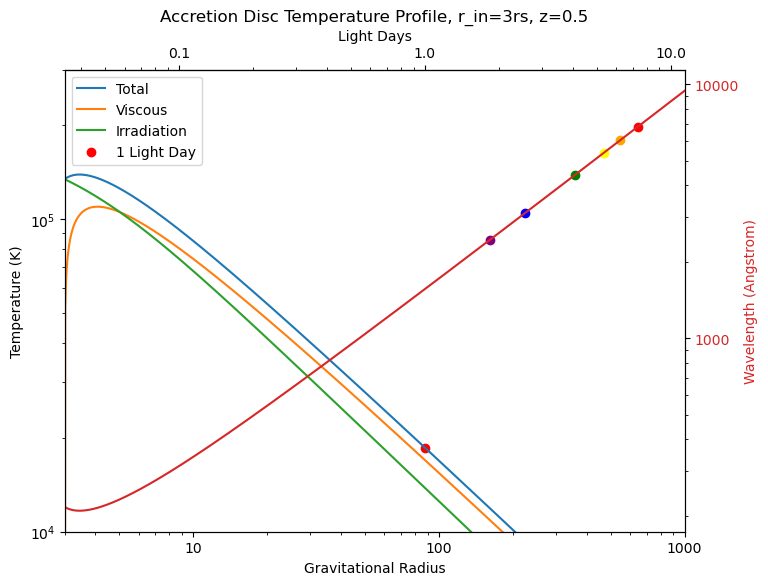

In [43]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

# Temperature at R0
temp_r0_index = np.where(radii >= ld)[0]
#print(temp_r0_index)	
temp_r0 = temp_prof[temp_r0_index[0]]
print(temp_r0)

emitting_lambda = weins_law(temp_prof)

# Rest Frame Wavelength
wav_index1 = np.where(emitting_lambda >= ders_wav_05[0])[0]
wav_index2 = np.where(emitting_lambda >= ders_wav_05[1])[0]
wav_index3 = np.where(emitting_lambda >= ders_wav_05[2])[0]
wav_index4 = np.where(emitting_lambda >= ders_wav_05[3])[0]
wav_index5 = np.where(emitting_lambda >= ders_wav_05[4])[0]
wav_index6 = np.where(emitting_lambda >= ders_wav_05[5])[0]
print(wav_index1[0],wav_index2[0],wav_index3[0],wav_index4[0],wav_index5[0])   



# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs, z=0.5')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(r_in, 1000)
axs.legend(loc='upper left')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.scatter(radii[wav_index1[0]]/rs, emitting_lambda[wav_index1[0]],color = 'purple')
ax2.scatter(radii[wav_index2[0]]/rs, emitting_lambda[wav_index2[0]],color = 'blue')
ax2.scatter(radii[wav_index3[0]]/rs, emitting_lambda[wav_index3[0]],color = 'green')
ax2.scatter(radii[wav_index4[0]]/rs, emitting_lambda[wav_index4[0]],color = 'yellow')
ax2.scatter(radii[wav_index5[0]]/rs, emitting_lambda[wav_index5[0]],color = 'orange')
ax2.scatter(radii[wav_index6[0]]/rs, emitting_lambda[wav_index6[0]],color = 'red')
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.set_ylim(100,8000)

#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

#fig.suptitle('Temp prof') 

18531.664869412354
618 674 755 803 828


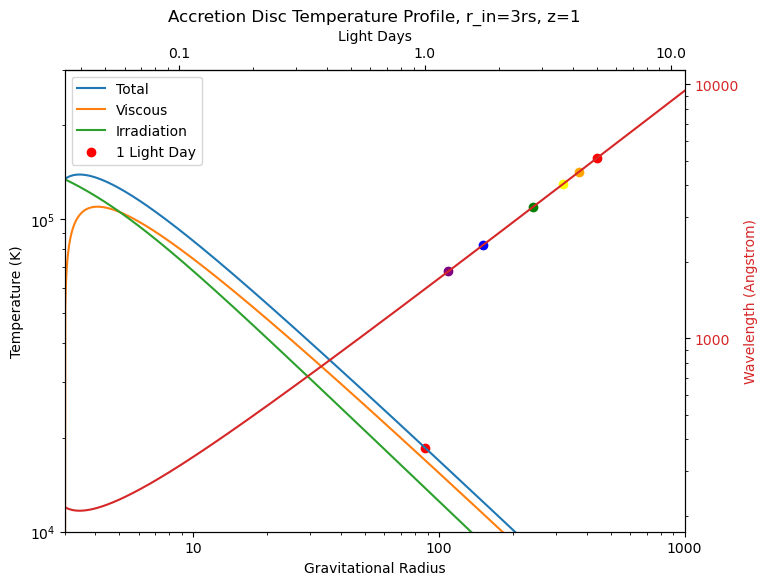

In [44]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

# Temperature at R0
temp_r0_index = np.where(radii >= ld)[0]
#print(temp_r0_index)	
temp_r0 = temp_prof[temp_r0_index[0]]
print(temp_r0)

emitting_lambda = weins_law(temp_prof)

# Rest Frame Wavelength
wav_index1 = np.where(emitting_lambda >= ders_wav_1[0])[0]
wav_index2 = np.where(emitting_lambda >= ders_wav_1[1])[0]
wav_index3 = np.where(emitting_lambda >= ders_wav_1[2])[0]
wav_index4 = np.where(emitting_lambda >= ders_wav_1[3])[0]
wav_index5 = np.where(emitting_lambda >= ders_wav_1[4])[0]
wav_index6 = np.where(emitting_lambda >= ders_wav_1[5])[0]
print(wav_index1[0],wav_index2[0],wav_index3[0],wav_index4[0],wav_index5[0])   



# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs, z=1')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(r_in, 1000)
axs.legend(loc='upper left')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.scatter(radii[wav_index1[0]]/rs, emitting_lambda[wav_index1[0]],color = 'purple')
ax2.scatter(radii[wav_index2[0]]/rs, emitting_lambda[wav_index2[0]],color = 'blue')
ax2.scatter(radii[wav_index3[0]]/rs, emitting_lambda[wav_index3[0]],color = 'green')
ax2.scatter(radii[wav_index4[0]]/rs, emitting_lambda[wav_index4[0]],color = 'yellow')
ax2.scatter(radii[wav_index5[0]]/rs, emitting_lambda[wav_index5[0]],color = 'orange')
ax2.scatter(radii[wav_index6[0]]/rs, emitting_lambda[wav_index6[0]],color = 'red')
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.set_ylim(100,8000)

#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

#fig.suptitle('Temp prof') 

18531.664869412354
522 579 661 708 734


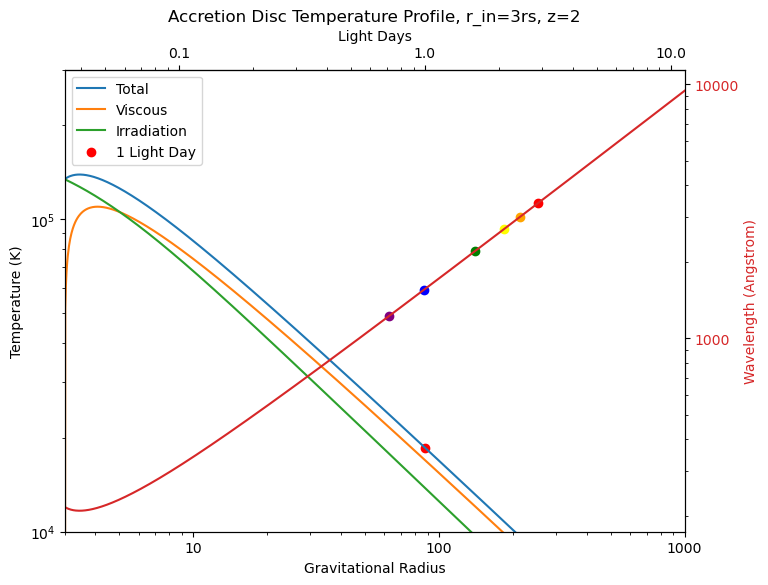

In [46]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

# Temperature at R0
temp_r0_index = np.where(radii >= ld)[0]
#print(temp_r0_index)	
temp_r0 = temp_prof[temp_r0_index[0]]
print(temp_r0)

emitting_lambda = weins_law(temp_prof)

# Rest Frame Wavelength
wav_index1 = np.where(emitting_lambda >= ders_wav_2[0])[0]
wav_index2 = np.where(emitting_lambda >= ders_wav_2[1])[0]
wav_index3 = np.where(emitting_lambda >= ders_wav_2[2])[0]
wav_index4 = np.where(emitting_lambda >= ders_wav_2[3])[0]
wav_index5 = np.where(emitting_lambda >= ders_wav_2[4])[0]
wav_index6 = np.where(emitting_lambda >= ders_wav_2[5])[0]
print(wav_index1[0],wav_index2[0],wav_index3[0],wav_index4[0],wav_index5[0])   



# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs, z=2')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(r_in, 1000)
axs.legend(loc='upper left')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.scatter(radii[wav_index1[0]]/rs, emitting_lambda[wav_index1[0]],color = 'purple')
ax2.scatter(radii[wav_index2[0]]/rs, emitting_lambda[wav_index2[0]],color = 'blue')
ax2.scatter(radii[wav_index3[0]]/rs, emitting_lambda[wav_index3[0]],color = 'green')
ax2.scatter(radii[wav_index4[0]]/rs, emitting_lambda[wav_index4[0]],color = 'yellow')
ax2.scatter(radii[wav_index5[0]]/rs, emitting_lambda[wav_index5[0]],color = 'orange')
ax2.scatter(radii[wav_index6[0]]/rs, emitting_lambda[wav_index6[0]],color = 'red')
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.set_ylim(100,8000)

#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

#fig.suptitle('Temp prof') 

18250
18250
18250
18250
18250
18250


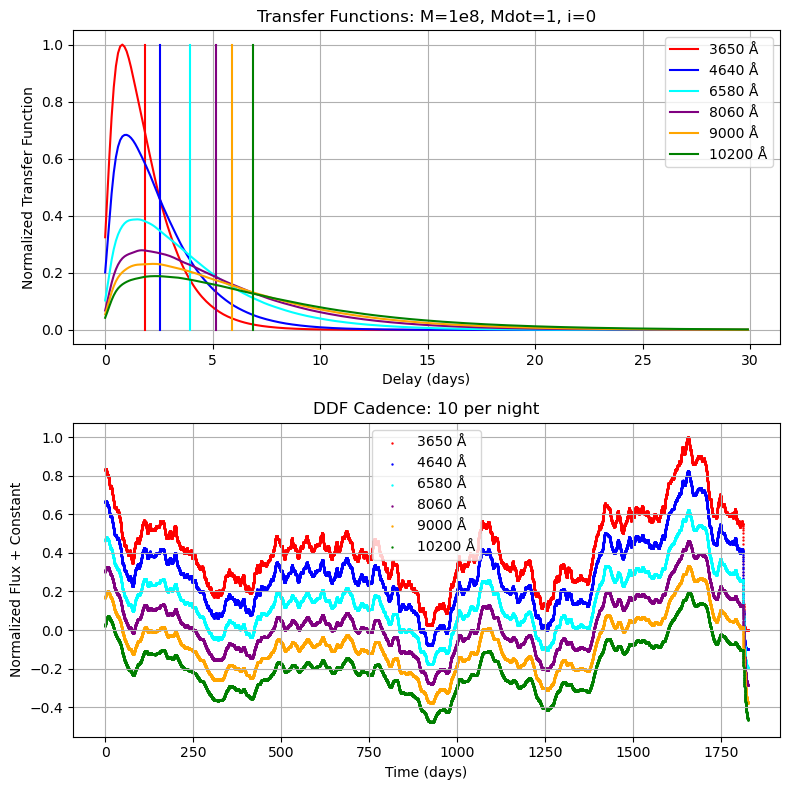

In [ ]:
from scipy.signal import convolve

color=['r','b','cyan','purple','orange','green','skyplue','magenta']
cadence = 10
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
for i, wav in enumerate(wavref):
    filename = '../Transfer_function/1e8M_1Mdot_0Deg/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == 3650.:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_lc, normalized_psis, mode='same', method='direct')
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    print(len(normalize_convolved_light_curve))
    # Normalize the convolved light curve
    #convolved_light_curve = convolved_light_curve #/ max(convolved_light_curve)
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    
    # Plot the convolved light curve
    axs[1].scatter(days[::1], normalize_convolved_light_curve[::1]-i*0.1,s=0.5,color=color[i], label=f'{int(wav)} Å')

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux + Constant')
axs[1].set_title('DDF Cadence: 10 per night')
axs[1].legend()
axs[1].grid()

plt.tight_layout()

plt.show()

In [59]:
print(10*365*5)

18250


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 332.60it/s]


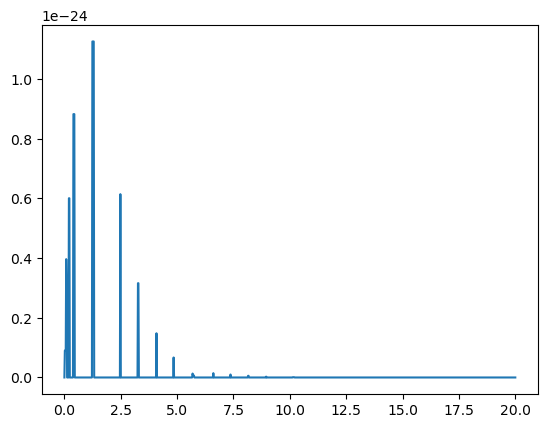

In [58]:
import numpy as np
from scipy.integrate import dblquad
from scipy.constants import c, h, k
day_s = 24*3600
# Define the integrand for the transfer function
def integrand_transfer(Theta,R , lam, TB, TF, R0, inclination, D,tau):
    tau_delay = (time_delay(R, Theta, inclination)) # in seconds
    if np.abs(tau/3600-tau_delay/3600) < 1:
        temp2 = TB * (R / R0)**-0.75  # Standard thin disc temperature profile
        temp1 = TF * (R / R0)**-0.75
        dB_dT = planck_function(c/lam, temp2) - planck_function(c/lam, temp1)
        return dB_dT * R * np.cos(inclination) / D**2
    else:
        return 0

# Define the wavelength range (in meters)
tau_array = []#np.linspace(0, 10*(24*3600), 10)  # delay in seconds

# Define the radius range (in m)
r_min = rs * 3
r_max = rs * 1000
phi_min = 0
phi_max = 360
lambda_obs = 4400e-10  # Wavelength in meters (e.g., 4400 Å)
i = np.radians(0)  # Inclination in radians
TB = 15000  # Bright state temperature in Kelvin
TF = 12000  # Faint state temperature in Kelvin
R0 = ld  # Reference radius in meters
radii = np.linspace(0*ld, 20*ld, 1000)# in light days
azimuths = np.linspace(0, 360, 1)
R, Phi = np.meshgrid(radii, azimuths, indexing='ij')
tau_array = time_delay(R, Phi, i)
tau_array = np.unique(np.array(tau_array))

# Compute the transfer function by integrating over the the disc
transfer_function = []
for tau in tqdm(tau_array):
    transfer_val, error = dblquad(integrand_transfer, r_min, r_max
                                  , lambda R: phi_min, lambda R: phi_max
                                  , args=(lambda_obs, TB, TF, R0, i, D,tau)
                                  , epsabs=1e-11, epsrel=1e-11)
    transfer_function.append(transfer_val)
'''
tf_sum = 0
# We now want to sum up this value for each tau value that corresponds to delay 
for tau in tqdm(tau_array):
    for radius in (radii):
        for Theta in azimuths:
            tau_delay = (time_delay(radius, Theta, i)) # in seconds
            #print(tau, tau_delay)
            if np.abs(tau-tau_delay) == 0:
                transfer_val, error = dblquad(integrand_transfer, r_min, radius
                                              , lambda R: phi_min, lambda R: phi_max
                                              , args=(lambda_obs, TB, TF, R0, i, D))
                tf_sum += transfer_val
    transfer_function.append(tf_sum)
'''
plt.plot(tau_array/(24*3600),transfer_function)